In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
def build_model(input_shape, output_frames):
    """
    Builds a CNN-based encoder-decoder model for animation frame prediction.
    
    Parameters:
    input_shape (tuple): The shape of the input frame (height, width, channels).
    output_frames (int): The number of frames to generate as output.
    
    Returns:
    model: The compiled Keras model.
    """
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    
    # CNN layers to encode the first frame
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Latent representation
    latent = layers.Dense(512, activation='relu', name='latent_vector')(x)

    # Decoder (generate multiple frames)
    decoder_output = layers.Dense(output_frames * input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(latent)
    decoder_output = layers.Reshape((output_frames, input_shape[0], input_shape[1], input_shape[2]), name='decoder_output')(decoder_output)

    # Build and compile the model
    model = models.Model(encoder_input, decoder_output, name='frame_predictor_model')
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [3]:
def process_sprite_data(sprite_sheet_paths, num_frames):
    """
    Processes sprite sheets and returns animation data without saving individual images.
    
    Parameters:
    sprite_sheet_paths (list): List of paths to the sprite sheet images.
    num_frames (int): Total number of frames (sprites) in the sprite sheet.
    
    Returns:
    X (numpy array): Array of input frames (first frame of each animation sequence).
    Y (numpy array): Array of output frames (remaining frames of each animation sequence).
    """
    # Initialize lists for input (X) and output (Y) frames
    X = []
    Y = []
    
    # Process each sprite sheet in the provided paths
    for i in range(len(sprite_sheet_paths)):
        sprite_sheet = Image.open(sprite_sheet_paths[i])
        
        # Get sprite sheet dimensions
        sheet_width, sheet_height = sprite_sheet.size
        
        # Calculate the width and height of each frame
        frame_width = sheet_width // num_frames
        frame_height = sheet_height  # Height of each frame is the same as the height of the sprite sheet
        
        # Loop through each frame in the sprite sheet
        for frame_num in range(num_frames):
            # Calculate the coordinates of the sprite in the sprite sheet
            left = frame_num * frame_width
            upper = 0
            right = left + frame_width
            lower = frame_height
            
            # Crop the sprite from the sprite sheet
            frame = sprite_sheet.crop((left, upper, right, lower))
            
            # Resize to 128x128 if needed and convert to RGB
            frame = frame.convert('RGB').resize((128, 128))
            
            # Normalize pixel values to [0, 1]
            frame_array = np.array(frame) / 255.0
            
            # Append the first frame to X and the remaining ones to Y
            if frame_num == 0:
                X.append(frame_array)  # The first frame goes into X
            else:
                if len(Y) <= i:  # Initialize the sublist for Y if necessary
                    Y.append([])
                Y[i].append(frame_array)  # Subsequent frames go into Y
    
    return np.array(X), np.array(Y)

In [16]:
def merge_frames(input_frame, output_frames):
    """
    Merge input_frame (1, 128, 128, 3) and output_frames (9, 128, 128, 3) into one array.
    
    Parameters:
    input_frame (numpy array): The first frame with shape (1, 128, 128, 3).
    output_frames (numpy array): The rest of the frames with shape (9, 128, 128, 3).

    Returns:
    numpy array: Merged frames with shape (10, 128, 128, 3).
    """    
    # Concatenate the input frame with the output frames
    merged_frames = np.concatenate(([input_frame], output_frames), axis=0)
    
    return merged_frames

In [5]:
def display_predicted_frames(predicted_frames):
    """
    Display predicted frames using Matplotlib.

    Parameters:
    predicted_frames (numpy array): Array of predicted frames.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure to display the frames
    plt.figure(figsize=(15, 5))

    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)  # Create a subplot for each frame
        plt.imshow(predicted_frames[i])  # Display the frame
        plt.axis('off')  # Hide the axes
        plt.title(f'Frame {i}')  # Optional: add title to each frame

    plt.tight_layout()  # Adjust subplots to fit in to the figure area.
    plt.show()  # Show the plot

In [6]:
def animate_frames(predicted_frames):
    """
    Create and display an animation from predicted frames in Jupyter Notebook.
    
    Parameters:
    predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure
    fig, ax = plt.subplots()

    # Display the first frame initially
    img = ax.imshow(predicted_frames[0], animated=True)
    ax.axis('off')  # Hide the axis for visual appeal

    # Update function for the animation
    def update(frame_num):
        img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
        return [img]

    # Create the animation: FuncAnimation creates a new image every interval
    ani = FuncAnimation(
        fig, update, frames=num_frames, interval=200, blit=True  # interval sets the frame display time (in ms)
    )

    # Display the animation in Jupyter
    plt.close(fig)  # Close the figure to prevent a static image from being displayed
    return HTML(ani.to_jshtml())  # Display the animation in HTML format


In [7]:
# Define input shape for 128x128x3 images
input_shape = (128, 128, 3)  # Height, Width, Channels
output_frames = 9  # Number of frames to predict

# Build the model
model = build_model(input_shape, output_frames)

# Print model summary
model.summary()

2024-10-24 09:35:17.013012: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-24 09:35:17.013040: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-24 09:35:17.013047: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-24 09:35:17.013409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-24 09:35:17.014031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "frame_predictor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 2

In [8]:
sprite_sheet_paths = ['/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_3_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_3_10f/Walk.png'
                     ] 
num_frames = 10  # Number of frames in the sprite sheet
X, Y = process_sprite_data(sprite_sheet_paths, num_frames)

print(f"X shape: {X.shape}")  # Should be (num_sequences, 128, 128, 3)
print(f"Y shape: {Y.shape}")  # Should be (num_sequences, 9, 128, 128, 3)

X shape: (6, 128, 128, 3)
Y shape: (6, 9, 128, 128, 3)


In [9]:
# Train the model
model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


2024-10-24 09:35:22.443797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.2440 - mae: 0.4921 - val_loss: 0.2450 - val_mae: 0.4935
Epoch 2/50


2024-10-24 09:35:23.941886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 441ms/step - loss: 0.2438 - mae: 0.4920 - val_loss: 0.2447 - val_mae: 0.4932
Epoch 3/50
1/1 [==============================] - 0s 440ms/step - loss: 0.2435 - mae: 0.4917 - val_loss: 0.2440 - val_mae: 0.4925
Epoch 4/50
1/1 [==============================] - 0s 425ms/step - loss: 0.2429 - mae: 0.4910 - val_loss: 0.2423 - val_mae: 0.4909
Epoch 5/50
1/1 [==============================] - 0s 431ms/step - loss: 0.2412 - mae: 0.4894 - val_loss: 0.2385 - val_mae: 0.4870
Epoch 6/50
1/1 [==============================] - 0s 403ms/step - loss: 0.2374 - mae: 0.4855 - val_loss: 0.2299 - val_mae: 0.4781
Epoch 7/50
1/1 [==============================] - 0s 413ms/step - loss: 0.2288 - mae: 0.4766 - val_loss: 0.2117 - val_mae: 0.4587
Epoch 8/50
1/1 [==============================] - 0s 423ms/step - loss: 0.2107 - mae: 0.4573 - val_loss: 0.1770 - val_mae: 0.4192
Epoch 9/50
1/1 [==============================] - 0s 414ms/step - loss: 0.1762 - mae: 0.4179 - val_lo

In [11]:
X[0].shape

(128, 128, 3)

In [13]:
predicted_frames = model.predict(np.expand_dims(X[0], axis=0))  # Add batch dimension

# Post-process the predicted frames if necessary
predicted_frames = predicted_frames.squeeze()  # Remove the batch dimension if needed
print(f"Predicted frames shape: {predicted_frames.shape}")  # Should be (9, 128, 128, 3)

# Optionally, save the predicted frames or display them
for i in range(predicted_frames.shape[0]):
    frame = (predicted_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]
    # Image.fromarray(frame).save(f"predicted_frame_{i}.png")

1/1 [==============================] - 0s 137ms/step


2024-10-24 09:41:28.248204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Predicted frames shape: (9, 128, 128, 3)


In [17]:
merged_frames = merge_frames(X[0], predicted_frames)
print("Merged shape:", merged_frames.shape)  # Expected Output: (10, 128, 128, 3)

Merged shape: (10, 128, 128, 3)


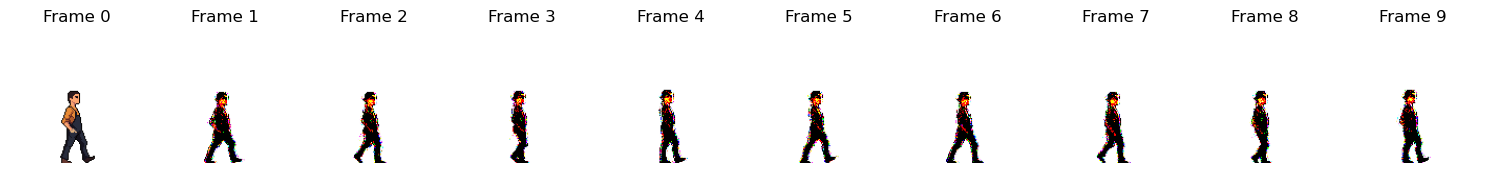

In [18]:
display_predicted_frames(merged_frames)

In [19]:
animate_frames(merged_frames)

In [16]:
img_path = "/Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.png"
input_img = Image.open(image_path).convert('RGB').resize((128, 128))
input_img = np.array(input_img)
input_img.shape

(128, 128, 3)

In [17]:
# # saving gif file

# def animate_frames(predicted_frames, save_path=None, fps=5):
#     """
#     Create, display, and optionally save an animation from predicted frames in Jupyter Notebook.
    
#     Parameters:
#     predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
#     save_path (str, optional): Path to save the animation (supports formats like .mp4 or .gif).
#     fps (int, optional): Frames per second for the animation. Default is 5 fps.
#     """
#     num_frames = predicted_frames.shape[0]

#     # Create a figure
#     fig, ax = plt.subplots()

#     # Display the first frame initially
#     img = ax.imshow(predicted_frames[0], animated=True)
#     ax.axis('off')  # Hide the axis for visual appeal

#     # Update function for the animation
#     def update(frame_num):
#         img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
#         return [img]

#     # Create the animation: FuncAnimation creates a new image every interval
#     ani = FuncAnimation(
#         fig, update, frames=num_frames, interval=1000//fps, blit=True  # interval in ms
#     )

#     if save_path:
#         # Save the animation
#         if save_path.endswith(".mp4"):
#             ani.save(save_path, writer="ffmpeg", fps=fps)
#         elif save_path.endswith(".gif"):
#             ani.save(save_path, writer="pillow", fps=fps)
#         print(f"Animation saved to {save_path}")
    
#     # Display the animation in Jupyter
#     plt.close(fig)  # Close the figure to prevent a static image from being displayed
#     return HTML(ani.to_jshtml())

# animate_frames(merged_frames, '/Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.gif', fps=5)

Animation saved to /Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.gif
